<a href="https://colab.research.google.com/github/elder-storck/Disciplina-Seguranca-em-Computacao/blob/main/notebooks/Lab_7_SegComp_Aprendizado_Federado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Laboratório \#7 - Aprendizado Federado usando a biblioteca Flower**
- Segurança em Computação 2025/2
- Prof. Rodolfo da Silva Villaça

# 🎯 Objetivos:

1. Experimentar o treinamento federado de modelos de aprendizado de máquina por meio do *framework* de aprendizado *flower*;

2. Comparar os resultados atingidos pelo modelo treinado de maneira local e federada.

# Atividade \#1: Experimentação de Aprendizado Federado com Flower e MNIST

Neste notebook, será implementado um experimento de aprendizado federado no qual múltiplos clientes treinam localmente um modelo de rede neural para classificação de imagens do MNIST. Cada cliente possui apenas uma partição local dos dados, e um servidor federado coordena o processo de agregação dos modelos por meio do algoritmo FedAvg.

O experimento será executado integralmente no ambiente Google Colab, simulando clientes federados localmente. A célula seguinte executa a instalação das bibliotecas necessárias.

### 1) Instalação de Bibliotecas

In [ ]:
!pip -q install protobuf==5.26.1
!pip -q install "grpcio-status==1.71.2" "flwr[simulation]" torch torchvision torchaudio --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flwr 1.25.0 requires protobuf<7.0.0,>=5.28.0, but you have protobuf 5.26.1 which is incompatible.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 5.26.1 which is incompatible.
ydf 0.14.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.


### 2) Imports e configuração do ambiente

Esta célula prepara o ambiente básico para a execução do experimento de **Aprendizado Federado**.  
São importadas as bibliotecas necessárias para:

- **Treinamento de modelos de aprendizado de máquina** (`torch`, `torchvision`);
- **Manipulação de dados e controle de aleatoriedade** (`numpy`, `random`);
- **Execução do aprendizado federado em modo de simulação** (`flwr`).

Além disso, é definido um **seed fixo** para garantir reprodutibilidade dos resultados e configurado automaticamente o **dispositivo de execução** (CPU ou GPU), utilizando GPU quando disponível no Google Colab.


In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import flwr as fl
from flwr.common import Context

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

### 3) Carregamento do dataset MNIST e particionamento dos dados

Esta célula realiza o **download, preparação e particionamento do dataset MNIST**, que contém imagens de dígitos manuscritos (0–9) e é amplamente utilizado em tarefas de classificação.

Inicialmente, são definidas **transformações de pré-processamento**, incluindo a conversão das imagens para tensores e a normalização dos valores de pixel. Em seguida, o dataset é carregado e dividido em **conjuntos de treino e teste**.

Para simular o cenário de **Aprendizado Federado**, o conjunto de treino é particionado de forma **IID (Independent and Identically Distributed)** entre múltiplos clientes federados. Cada cliente recebe apenas uma fração local dos dados e treina o modelo de forma independente, sem acesso aos dados dos demais clientes. Por fim, são definidos os *dataloaders* que serão utilizados no treinamento e na avaliação local de cada cliente.


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

def partition_dataset_iid(dataset, num_clients: int):
    """Particiona IID: divide índices em blocos iguais por cliente."""
    n = len(dataset)
    indices = np.random.permutation(n)
    splits = np.array_split(indices, num_clients)
    return [split.tolist() for split in splits]

NUM_CLIENTS = 5
client_partitions = partition_dataset_iid(trainset, NUM_CLIENTS)

BATCH_SIZE = 32

def get_client_loaders(cid: int):
    if not (0 <= cid < NUM_CLIENTS):
        raise ValueError(f"cid inválido: {cid} (esperado 0..{NUM_CLIENTS-1})")

    train_idx = client_partitions[cid]
    trainloader = DataLoader(Subset(trainset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(testset, batch_size=256, shuffle=False)
    return trainloader, testloader



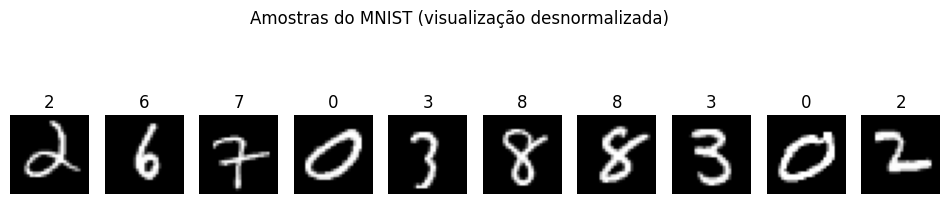

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parâmetros da normalização usada acima
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

def denormalize(img_tensor):
    # img_tensor: [1, 28, 28]
    return img_tensor * MNIST_STD + MNIST_MEAN

# Seleciona algumas amostras aleatórias
num_samples = 10
idxs = np.random.choice(len(trainset), size=num_samples, replace=False)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(idxs):
    x, y = trainset[idx]  # x já está normalizado
    x_vis = denormalize(x).squeeze(0).cpu().numpy()  # (28, 28)

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x_vis, cmap="gray")
    plt.title(str(y))
    plt.axis("off")

plt.suptitle("Amostras do MNIST (visualização desnormalizada)")
plt.show()


### 4) Definição do modelo de rede neural

Nesta célula é definida a **arquitetura do modelo de aprendizado de máquina** utilizado no experimento. O modelo consiste em uma **rede neural convolucional (CNN) simples**, adequada para tarefas de classificação de imagens como o MNIST.

A arquitetura é composta por camadas convolucionais para extração de características espaciais, seguidas de camadas totalmente conectadas responsáveis pela classificação final dos dígitos. Essa escolha permite manter o modelo **leve e computacionalmente eficiente**, o que é desejável em cenários de aprendizado federado, onde os clientes podem possuir recursos limitados.

Também é definida uma função auxiliar para instanciar o modelo e movê-lo automaticamente para o **dispositivo de execução** (CPU ou GPU), garantindo compatibilidade com o ambiente do Google Colab.


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)         # 28 -> 14
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)         # 14 -> 7
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def get_model():
    return SimpleCNN().to(DEVICE)


### 5) Funções de treinamento e avaliação do modelo

Esta célula define as **rotinas locais de treinamento e avaliação** que serão executadas por cada cliente federado.  

A função de treinamento realiza uma **época de aprendizado supervisionado**, ajustando os pesos do modelo a partir dos dados locais do cliente por meio de retropropagação do erro e atualização dos parâmetros com um otimizador gradiente-descendente.

Já a função de avaliação mede o desempenho do modelo no conjunto de teste, calculando métricas como **função de perda** e **acurácia de classificação**. Essa avaliação permite acompanhar a qualidade do modelo global ao longo das rodadas federadas.

Essas funções são reutilizadas por todos os clientes e representam o comportamento local típico em um cenário de **Aprendizado Federado**, no qual cada participante treina e avalia o modelo apenas com seus próprios dados.


In [ ]:
def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for x, y in trainloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(trainloader.dataset)

@torch.no_grad()
def evaluate(model, testloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y in testloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


### 6) Implementação do cliente federado com Flower

Nesta célula é implementado o **cliente federado** utilizando a interface `NumPyClient` do framework **Flower**. Cada cliente representa um participante do sistema de aprendizado federado e é responsável por treinar o modelo localmente e reportar seus parâmetros ao servidor.

O cliente implementa três métodos principais:
- **`get_parameters`**: retorna os pesos atuais do modelo local;
- **`fit`**: executa o treinamento local a partir dos parâmetros recebidos do servidor;
- **`evaluate`**: avalia o modelo local e retorna métricas de desempenho, como perda e acurácia.

Cada instância do cliente opera apenas sobre sua **partição local dos dados**, não compartilhando dados brutos com o servidor ou com outros clientes. Esse comportamento ilustra o princípio fundamental do **Aprendizado Federado**, no qual apenas os parâmetros do modelo são comunicados durante o processo de treinamento distribuído.


In [ ]:
def get_parameters(model):
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

def set_parameters(model, parameters):
    state_dict = model.state_dict()
    keys = list(state_dict.keys())
    new_state_dict = {k: torch.tensor(v) for k, v in zip(keys, parameters)}
    model.load_state_dict(new_state_dict, strict=True)

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid: int):
        self.cid = cid
        self.model = get_model()
        self.trainloader, self.testloader = get_client_loaders(cid)
        self.criterion = nn.CrossEntropyLoss()

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)

        lr = float(config.get("lr", 0.01))
        local_epochs = int(config.get("local_epochs", 1))

        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)

        for _ in range(local_epochs):
            train_one_epoch(self.model, self.trainloader, optimizer, self.criterion)

        return get_parameters(self.model), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        loss, acc = evaluate(self.model, self.testloader, self.criterion)
        return float(loss), len(self.testloader.dataset), {"accuracy": float(acc)}


### 7) Função de criação dos clientes (`client_fn`)

Nesta célula é definida a função `client_fn`, responsável por instanciar os clientes federados no modo de simulação do Flower, seguindo a **API atual do framework**.

O Flower fornece um objeto de contexto (`Context`) que contém informações sobre o cliente, como seu identificador (`node_id`). A partir desse identificador, é criada uma instância do cliente federado, que inicialmente implementa a interface `NumPyClient`.

Por compatibilidade com a API mais recente do Flower, o cliente é convertido explicitamente para o tipo `Client` antes de ser retornado ao servidor. Esse mecanismo garante maior flexibilidade e compatibilidade futura do código.



In [ ]:
from flwr.common import Context

def client_fn(context: Context):
    node_id = int(context.node_id)

    # Compatível com node_id começando em 1 (1..NUM_CLIENTS)
    if 1 <= node_id <= NUM_CLIENTS:
        cid = node_id - 1
    else:
        # Fallback seguro caso venha fora do esperado
        cid = node_id % NUM_CLIENTS

    return FlowerClient(cid).to_client()


### 8) Configuração da estratégia federada e execução da simulação

Nesta célula é configurada a **estratégia de agregação federada** utilizada pelo servidor, baseada no algoritmo **FedAvg (Federated Averaging)**, que combina os modelos treinados localmente pelos clientes para atualizar o modelo global.

São definidos parâmetros como:
- a fração de clientes participantes em cada rodada;
- o número mínimo de clientes disponíveis;
- o número total de rodadas federadas;
- a configuração de hiperparâmetros enviados aos clientes (por exemplo, taxa de aprendizado e número de épocas locais).

Em seguida, a simulação é iniciada por meio da função `start_simulation`, que coordena a interação entre o servidor e os clientes ao longo das rodadas federadas. Durante esse processo, os clientes treinam localmente seus modelos e o servidor agrega os parâmetros, simulando um ambiente completo de **Aprendizado Federado** de forma centralizada no Google Colab.


In [ ]:
# Config de treino (enviada para os clientes a cada rodada)
def fit_config(server_round: int):
    return {
        "lr": 0.01,
        "local_epochs": 1,
    }

def evaluate_metrics_aggregation_fn(metrics):
    # metrics: List[Tuple[num_examples, Dict[str, Scalar]]]
    total_examples = sum(n for n, _ in metrics)
    agg = {}
    for n, m in metrics:
        for k, v in m.items():
            agg[k] = agg.get(k, 0.0) + (n / total_examples) * float(v)
    return agg

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)


NUM_ROUNDS = 3

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

          

*texto em itálico*### 9) Visualização das métricas distribuídas

Nesta célula são exibidos os **resultados agregados da avaliação distribuída** ao longo das rodadas de aprendizado federado.

- **Loss (distributed)**: representa a função de perda média do modelo global, calculada a partir das avaliações realizadas pelos clientes federados e agregada pelo servidor a cada rodada.
- **Metrics (distributed)**: contém as métricas adicionais reportadas pelos clientes durante a fase de avaliação, após o processo de agregação federada.
- **Accuracy (distributed)**: mostra a evolução da acurácia do modelo global ao longo das rodadas, refletindo o desempenho do aprendizado federado no conjunto de teste.

Essas métricas permitem analisar a **convergência do modelo federado** e comparar seu comportamento ao longo das rodadas de treinamento.


In [ ]:
print("Loss (distributed):", history.losses_distributed)
print("Metrics (distributed):", history.metrics_distributed)
print("Accuracy (distributed):", history.metrics_distributed.get("accuracy", []))



Loss (distributed): [(1, 0.11187381826341153), (2, 0.05940710793584585), (3, 0.0484902721228078)]
Metrics (distributed): {'accuracy': [(1, 0.9674), (2, 0.9806000000000001), (3, 0.9839)]}
Accuracy (distributed): [(1, 0.9674), (2, 0.9806000000000001), (3, 0.9839)]


### 10) Evolução da Acurácia do Modelo Federado

Esta célula extrai a **acurácia agregada** do histórico do aprendizado federado e plota sua evolução ao longo das rodadas. O gráfico permite visualizar a **convergência do modelo federado** durante o treinamento.


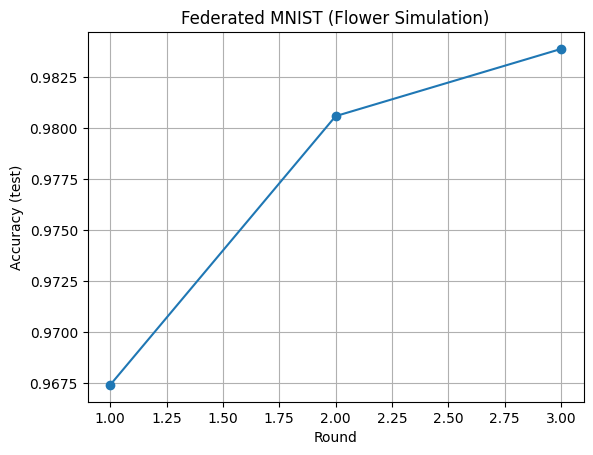

In [ ]:
import matplotlib.pyplot as plt

# Extrai o histórico correto
acc_hist = history.metrics_distributed.get("accuracy", [])

if len(acc_hist) == 0:
    print("Nenhuma métrica de acurácia encontrada.")
else:
    rounds = [r for r, _ in acc_hist]
    accs = [a for _, a in acc_hist]

    plt.figure()
    plt.plot(rounds, accs, marker="o")
    plt.xlabel("Round")
    plt.ylabel("Accuracy (test)")
    plt.title("Federated MNIST (Flower Simulation)")
    plt.grid(True)
    plt.show()



### 11) Treinamento Local (Baseline)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Hiperparâmetros (ajuste se quiser comparar com o federado)
CENTRAL_EPOCHS = 3
CENTRAL_LR = 0.01
CENTRAL_BATCH_SIZE = 32

# DataLoaders centralizados (usa TODO o treino e avalia no teste)
central_trainloader = DataLoader(trainset, batch_size=CENTRAL_BATCH_SIZE, shuffle=True)
central_testloader = DataLoader(testset, batch_size=256, shuffle=False)

# Modelo + otimizador
model_central = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_central.parameters(), lr=CENTRAL_LR, momentum=0.9)

central_train_losses = []
central_test_losses = []
central_test_accs = []

for epoch in range(1, CENTRAL_EPOCHS + 1):
    train_loss = train_one_epoch(model_central, central_trainloader, optimizer, criterion)
    test_loss, test_acc = evaluate(model_central, central_testloader, criterion)

    central_train_losses.append(train_loss)
    central_test_losses.append(test_loss)
    central_test_accs.append(test_acc)

    print(
        f"[Central] Epoch {epoch}/{CENTRAL_EPOCHS} | "
        f"train_loss={train_loss:.4f} | test_loss={test_loss:.4f} | test_acc={test_acc:.4f}"
    )


[Central] Epoch 1/3 | train_loss=0.1613 | test_loss=0.0840 | test_acc=0.9727
[Central] Epoch 2/3 | train_loss=0.0479 | test_loss=0.0377 | test_acc=0.9870
[Central] Epoch 3/3 | train_loss=0.0332 | test_loss=0.0353 | test_acc=0.9882


### 13) Comparação: Federado × Centralizado

Compara a evolução da acurácia do modelo treinado de forma federada (por rodada)
com o treinamento centralizado tradicional (por época), usando o mesmo dataset MNIST.


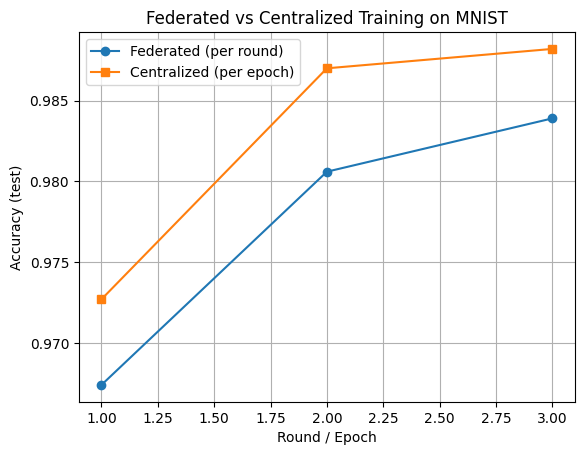

In [ ]:
import matplotlib.pyplot as plt

# --- Federated accuracy (por round) ---
fed_acc_hist = history.metrics_distributed.get("accuracy", [])
fed_rounds = [r for r, _ in fed_acc_hist]
fed_accs = [a for _, a in fed_acc_hist]

# --- Centralized accuracy (por epoch) ---
central_epochs = list(range(1, len(central_test_accs) + 1))
central_accs = central_test_accs

plt.figure()
plt.plot(fed_rounds, fed_accs, marker="o", label="Federated (per round)")
plt.plot(central_epochs, central_accs, marker="s", label="Centralized (per epoch)")
plt.xlabel("Round / Epoch")
plt.ylabel("Accuracy (test)")
plt.title("Federated vs Centralized Training on MNIST")
plt.grid(True)
plt.legend()
plt.show()



#### Atividades

## Atividade \#1: Impacto do Número de Rounds no Aprendizado Federado

Durante a configuração do aprendizado federado, diversos hiperparâmetros podem ser ajustados. Um dos mais importantes é o **número de rounds**, que define quantas vezes o modelo global é atualizado a partir dos modelos treinados localmente pelos clientes.

Nesta atividade, você deverá **executar o treinamento federado variando o número de rounds** e analisar o impacto dessa escolha no desempenho do modelo.

### Tarefas
- Treinar o modelo federado utilizando **10, 15 e 20 rounds**.
- Para cada valor de rounds:
  - registrar a **acurácia final** do modelo federado;
  - plotar um **gráfico de linha** relacionando o número de rounds com a acurácia obtida.
- Executar o **treinamento centralizado** da mesma rede neural.
- Comparar o desempenho do modelo federado (para diferentes números de rounds) com o desempenho do modelo treinado de forma centralizada.

### Entregável
- Gráficos gerados no notebook.
- Breve análise comparativa dos resultados obtidos.





### Configuração da estratégia federada e execução da simulação com 10 ROUNDS


In [ ]:
# Config de treino (enviada para os clientes a cada rodada)
def fit_config(server_round: int):
    return {
        "lr": 0.01,
        "local_epochs": 1,
    }

def evaluate_metrics_aggregation_fn(metrics):
    # metrics: List[Tuple[num_examples, Dict[str, Scalar]]]
    total_examples = sum(n for n, _ in metrics)
    agg = {}
    for n, m in metrics:
        for k, v in m.items():
            agg[k] = agg.get(k, 0.0) + (n / total_examples) * float(v)
    return agg

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)


In [ ]:
NUM_ROUNDS = 10

history_10 = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2026-01-28 02:00:45,978	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 9278127309.0, 'node:172.28.0.12': 1.0, 'node:__i

In [ ]:
print("Loss (distributed):", history_10.losses_distributed)
print("Metrics (distributed):", history_10.metrics_distributed)
print("Accuracy (distributed):", history_10.metrics_distributed.get("accuracy", []))


Loss (distributed): [(1, 0.10783004150688648), (2, 0.05798017071783543), (3, 0.04536008825227617), (4, 0.03763595251366496), (5, 0.037164916153252125), (6, 0.03381316377501935), (7, 0.03101974818650633), (8, 0.029481313155870884), (9, 0.0295303118432872), (10, 0.031712897572806105)]
Metrics (distributed): {'accuracy': [(1, 0.9677000000000001), (2, 0.9810000000000001), (3, 0.9854000000000002), (4, 0.9872000000000001), (5, 0.9875), (6, 0.9891), (7, 0.9906000000000001), (8, 0.9902), (9, 0.9910000000000001), (10, 0.9901)]}
Accuracy (distributed): [(1, 0.9677000000000001), (2, 0.9810000000000001), (3, 0.9854000000000002), (4, 0.9872000000000001), (5, 0.9875), (6, 0.9891), (7, 0.9906000000000001), (8, 0.9902), (9, 0.9910000000000001), (10, 0.9901)]


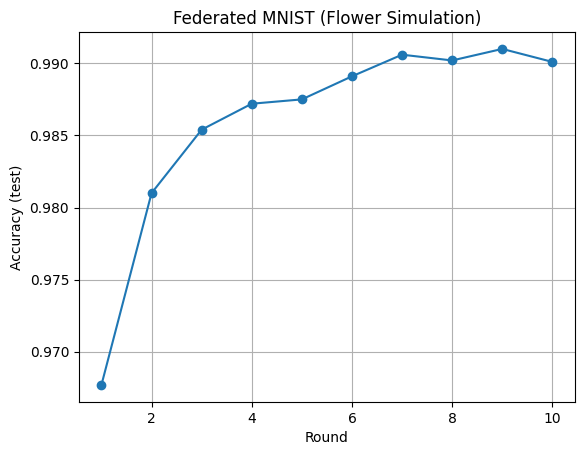

In [ ]:
import matplotlib.pyplot as plt

# Extrai o histórico correto
acc_hist = history_10.metrics_distributed.get("accuracy", [])

if len(acc_hist) == 0:
    print("Nenhuma métrica de acurácia encontrada.")
else:
    rounds = [r for r, _ in acc_hist]
    accs = [a for _, a in acc_hist]

    plt.figure()
    plt.plot(rounds, accs, marker="o")
    plt.xlabel("Round")
    plt.ylabel("Accuracy (test)")
    plt.title("Federated MNIST (Flower Simulation)")
    plt.grid(True)
    plt.show()



### Configuração da estratégia federada e execução da simulação com 15 ROUNDS

In [ ]:
# Config de treino (enviada para os clientes a cada rodada)
def fit_config(server_round: int):
    return {
        "lr": 0.01,
        "local_epochs": 1,
    }

def evaluate_metrics_aggregation_fn(metrics):
    # metrics: List[Tuple[num_examples, Dict[str, Scalar]]]
    total_examples = sum(n for n, _ in metrics)
    agg = {}
    for n, m in metrics:
        for k, v in m.items():
            agg[k] = agg.get(k, 0.0) + (n / total_examples) * float(v)
    return agg

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)

NUM_ROUNDS = 15

history_15 = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout
2026-01-28 00:30:18,564	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'o

In [ ]:
print("Loss (distributed):", history_15.losses_distributed)
print("Metrics (distributed):", history_15.metrics_distributed)
print("Accuracy (distributed):", history_15.metrics_distributed.get("accuracy", []))


Loss (distributed): [(1, 0.10933189435005188), (2, 0.06219727419540286), (3, 0.046800334776192894), (4, 0.039760457301326095), (5, 0.03436168420538306), (6, 0.03258248675977811), (7, 0.031626188744790854), (8, 0.033630119002982975), (9, 0.03087512971868273), (10, 0.02999094650556799), (11, 0.029873593673016875), (12, 0.02959785456908867), (13, 0.028303650152939373), (14, 0.03184167806320765), (15, 0.03095949442656711)]
Metrics (distributed): {'accuracy': [(1, 0.9662), (2, 0.9809000000000001), (3, 0.9848000000000001), (4, 0.9860000000000001), (5, 0.9888000000000001), (6, 0.9895), (7, 0.9898000000000001), (8, 0.9894000000000001), (9, 0.9899000000000001), (10, 0.9912), (11, 0.9915000000000002), (12, 0.9907), (13, 0.9913), (14, 0.9896), (15, 0.9905000000000002)]}
Accuracy (distributed): [(1, 0.9662), (2, 0.9809000000000001), (3, 0.9848000000000001), (4, 0.9860000000000001), (5, 0.9888000000000001), (6, 0.9895), (7, 0.9898000000000001), (8, 0.9894000000000001), (9, 0.9899000000000001), (10,

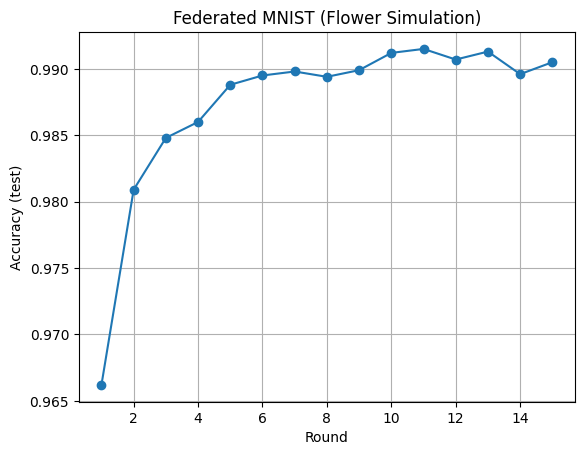

In [ ]:
import matplotlib.pyplot as plt

# Extrai o histórico correto
acc_hist = history_15.metrics_distributed.get("accuracy", [])

if len(acc_hist) == 0:
    print("Nenhuma métrica de acurácia encontrada.")
else:
    rounds = [r for r, _ in acc_hist]
    accs = [a for _, a in acc_hist]

    plt.figure()
    plt.plot(rounds, accs, marker="o")
    plt.xlabel("Round")
    plt.ylabel("Accuracy (test)")
    plt.title("Federated MNIST (Flower Simulation)")
    plt.grid(True)
    plt.show()



### Configuração da estratégia federada e execução da simulação com 20 ROUNDS

In [ ]:
NUM_ROUNDS = 20

history_20 = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
2026-01-28 00:47:41,812	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 9279087821.0, 'node:172.28.0.12': 1.0, 'node:__i

In [ ]:
print("Loss (distributed):", history_20.losses_distributed)
print("Metrics (distributed):", history_20.metrics_distributed)
print("Accuracy (distributed):", history_20.metrics_distributed.get("accuracy", []))


Loss (distributed): [(1, 0.09221334667503833), (2, 0.05914528409764171), (3, 0.04330855097323656), (4, 0.03665007592090406), (5, 0.03234848105928395), (6, 0.030792703970451838), (7, 0.02920589327359339), (8, 0.02745501267480431), (9, 0.028603589951683533), (10, 0.02792186404588865), (11, 0.026603670008524205), (12, 0.025099304624670186), (13, 0.025457839351374422), (14, 0.027504118218499934), (15, 0.02364470708852168), (16, 0.026049298708562856), (17, 0.028047870411531766), (18, 0.026754589765474155), (19, 0.026895992330201263), (20, 0.025688947038990773)]
Metrics (distributed): {'accuracy': [(1, 0.9706000000000001), (2, 0.9811000000000001), (3, 0.9844000000000002), (4, 0.9876000000000001), (5, 0.9891), (6, 0.9895), (7, 0.9905000000000002), (8, 0.9907), (9, 0.9899000000000001), (10, 0.9909000000000001), (11, 0.9919), (12, 0.9928000000000001), (13, 0.9920000000000001), (14, 0.9914000000000001), (15, 0.9926000000000001), (16, 0.9921000000000001), (17, 0.9919), (18, 0.9918), (19, 0.992000

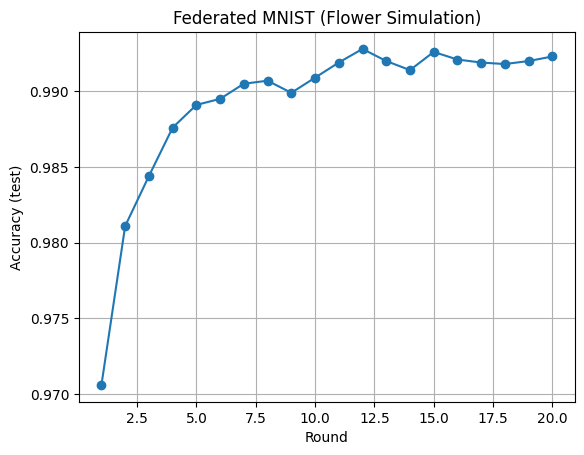

In [ ]:
import matplotlib.pyplot as plt

# Extrai o histórico correto
acc_hist = history_20.metrics_distributed.get("accuracy", [])

if len(acc_hist) == 0:
    print("Nenhuma métrica de acurácia encontrada.")
else:
    rounds = [r for r, _ in acc_hist]
    accs = [a for _, a in acc_hist]

    plt.figure()
    plt.plot(rounds, accs, marker="o")
    plt.xlabel("Round")
    plt.ylabel("Accuracy (test)")
    plt.title("Federated MNIST (Flower Simulation)")
    plt.grid(True)
    plt.show()



## Conclusão do modelo federado
Os experimentos mostraram que o modelo federado apresentou rápida convergência nas primeiras rodadas, com redução significativa da função de perda e aumento consistente da acurácia. A partir de aproximadamente 10 rodadas, os ganhos tornam-se marginais, indicando que o modelo atinge um platô de aprendizado. O melhor desempenho foi obtido com 20 rodadas, alcançando acurácia de aproximadamente 99,23%, porém com custo adicional de comunicação e tempo de treinamento. Isso demonstra que, para este cenário, cerca de 10 a 15 rodadas já são suficientes para atingir desempenho próximo ao máximo.

#Treinamento Local (Baseline) com 10 épocas

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Hiperparâmetros (ajuste se quiser comparar com o federado)
CENTRAL_EPOCHS_10 = 10
CENTRAL_EPOCHS_15 = 15
CENTRAL_EPOCHS_20 = 20
CENTRAL_LR = 0.01
CENTRAL_BATCH_SIZE = 32

# DataLoaders centralizados (usa TODO o treino e avalia no teste)
central_trainloader = DataLoader(trainset, batch_size=CENTRAL_BATCH_SIZE, shuffle=True)
central_testloader = DataLoader(testset, batch_size=256, shuffle=False)

# Modelo + otimizador
model_central = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_central.parameters(), lr=CENTRAL_LR, momentum=0.9)


In [ ]:
# Modelo + otimizador
model_central = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_central.parameters(), lr=CENTRAL_LR, momentum=0.9)

central_train_losses_10 = []
central_test_losses_10 = []
central_test_accs_10 = []

for epoch in range(1, CENTRAL_EPOCHS_10 + 1):
    train_loss = train_one_epoch(model_central, central_trainloader, optimizer, criterion)
    test_loss, test_acc = evaluate(model_central, central_testloader, criterion)

    central_train_losses_10.append(train_loss)
    central_test_losses_10.append(test_loss)
    central_test_accs_10.append(test_acc)

    print(
        f"[Central] Epoch {epoch}/{CENTRAL_EPOCHS_10} | "
        f"train_loss={train_loss:.4f} | test_loss={test_loss:.4f} | test_acc={test_acc:.4f}"
    )

[Central] Epoch 1/10 | train_loss=0.1580 | test_loss=0.0484 | test_acc=0.9837
[Central] Epoch 2/10 | train_loss=0.0463 | test_loss=0.0322 | test_acc=0.9889
[Central] Epoch 3/10 | train_loss=0.0311 | test_loss=0.0327 | test_acc=0.9888
[Central] Epoch 4/10 | train_loss=0.0244 | test_loss=0.0285 | test_acc=0.9910
[Central] Epoch 5/10 | train_loss=0.0169 | test_loss=0.0308 | test_acc=0.9911
[Central] Epoch 6/10 | train_loss=0.0140 | test_loss=0.0295 | test_acc=0.9905
[Central] Epoch 7/10 | train_loss=0.0113 | test_loss=0.0341 | test_acc=0.9904
[Central] Epoch 8/10 | train_loss=0.0097 | test_loss=0.0474 | test_acc=0.9867
[Central] Epoch 9/10 | train_loss=0.0077 | test_loss=0.0289 | test_acc=0.9910
[Central] Epoch 10/10 | train_loss=0.0072 | test_loss=0.0316 | test_acc=0.9908


## Comparação: Federado × Centralizado (10 épocas)

*   Item da lista
*   Item da lista



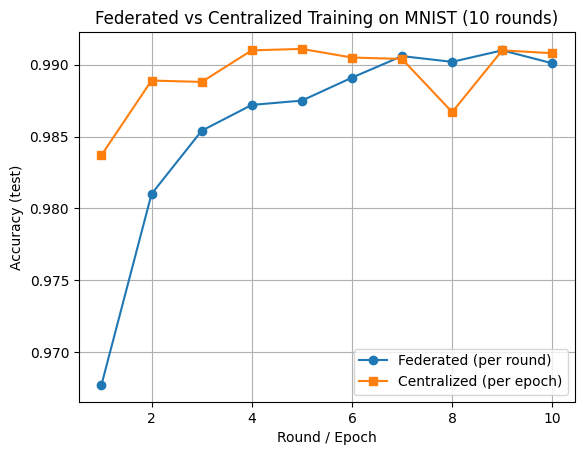

In [ ]:
import matplotlib.pyplot as plt

# --- Federated accuracy (por round) ---
fed_acc_hist = history_10.metrics_distributed.get("accuracy", [])
fed_rounds = [r for r, _ in fed_acc_hist]
fed_accs = [a for _, a in fed_acc_hist]

# --- Centralized accuracy (por epoch) ---
central_epochs = list(range(1, len(central_test_accs_10) + 1))
central_accs = central_test_accs_10

plt.figure()
plt.plot(fed_rounds, fed_accs, marker="o", label="Federated (per round)")
plt.plot(central_epochs, central_accs, marker="s", label="Centralized (per epoch)")
plt.xlabel("Round / Epoch")
plt.ylabel("Accuracy (test)")
plt.title("Federated vs Centralized Training on MNIST (10 rounds)")
plt.grid(True)
plt.legend()
plt.show()



#Treinamento Local (Baseline) com 15 épocas:

In [ ]:
# Modelo + otimizador
model_central = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_central.parameters(), lr=CENTRAL_LR, momentum=0.9)

central_train_losses_15 = []
central_test_losses_15 = []
central_test_accs_15 = []

for epoch in range(1, CENTRAL_EPOCHS_15 + 1):
    train_loss = train_one_epoch(model_central, central_trainloader, optimizer, criterion)
    test_loss, test_acc = evaluate(model_central, central_testloader, criterion)

    central_train_losses_15.append(train_loss)
    central_test_losses_15.append(test_loss)
    central_test_accs_15.append(test_acc)

    print(
        f"[Central] Epoch {epoch}/{CENTRAL_EPOCHS_15} | "
        f"train_loss={train_loss:.4f} | test_loss={test_loss:.4f} | test_acc={test_acc:.4f}"
    )

[Central] Epoch 1/15 | train_loss=0.1600 | test_loss=0.0424 | test_acc=0.9864
[Central] Epoch 2/15 | train_loss=0.0462 | test_loss=0.0321 | test_acc=0.9893
[Central] Epoch 3/15 | train_loss=0.0311 | test_loss=0.0396 | test_acc=0.9869
[Central] Epoch 4/15 | train_loss=0.0224 | test_loss=0.0282 | test_acc=0.9907
[Central] Epoch 5/15 | train_loss=0.0170 | test_loss=0.0279 | test_acc=0.9904
[Central] Epoch 6/15 | train_loss=0.0152 | test_loss=0.0274 | test_acc=0.9920
[Central] Epoch 7/15 | train_loss=0.0111 | test_loss=0.0288 | test_acc=0.9904
[Central] Epoch 8/15 | train_loss=0.0090 | test_loss=0.0469 | test_acc=0.9883
[Central] Epoch 9/15 | train_loss=0.0084 | test_loss=0.0465 | test_acc=0.9875
[Central] Epoch 10/15 | train_loss=0.0053 | test_loss=0.0388 | test_acc=0.9909
[Central] Epoch 11/15 | train_loss=0.0052 | test_loss=0.0522 | test_acc=0.9877
[Central] Epoch 12/15 | train_loss=0.0037 | test_loss=0.0393 | test_acc=0.9907
[Central] Epoch 13/15 | train_loss=0.0035 | test_loss=0.0346 

## Comparação: Federado × Centralizado (15 épocas)


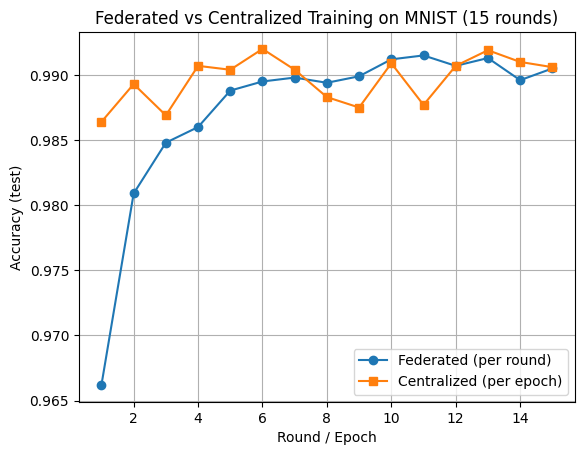

In [ ]:
import matplotlib.pyplot as plt

# --- Federated accuracy (por round) ---
fed_acc_hist = history_15.metrics_distributed.get("accuracy", [])
fed_rounds = [r for r, _ in fed_acc_hist]
fed_accs = [a for _, a in fed_acc_hist]

# --- Centralized accuracy (por epoch) ---
central_epochs = list(range(1, len(central_test_accs_15) + 1))
central_accs = central_test_accs_15

plt.figure()
plt.plot(fed_rounds, fed_accs, marker="o", label="Federated (per round)")
plt.plot(central_epochs, central_accs, marker="s", label="Centralized (per epoch)")
plt.xlabel("Round / Epoch")
plt.ylabel("Accuracy (test)")
plt.title("Federated vs Centralized Training on MNIST (15 rounds)")
plt.grid(True)
plt.legend()
plt.show()



#Treinamento Local (Baseline) com 20 épocas:

In [ ]:
# Modelo + otimizador
model_central = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_central.parameters(), lr=CENTRAL_LR, momentum=0.9)

central_train_losses_15 = []
central_test_losses_15 = []
central_test_accs_20 = []

for epoch in range(1, CENTRAL_EPOCHS_20 + 1):
    train_loss = train_one_epoch(model_central, central_trainloader, optimizer, criterion)
    test_loss, test_acc = evaluate(model_central, central_testloader, criterion)

    central_train_losses_15.append(train_loss)
    central_test_losses_15.append(test_loss)
    central_test_accs_20.append(test_acc)

    print(
        f"[Central] Epoch {epoch}/{CENTRAL_EPOCHS_20} | "
        f"train_loss={train_loss:.4f} | test_loss={test_loss:.4f} | test_acc={test_acc:.4f}"
    )

[Central] Epoch 1/20 | train_loss=0.1555 | test_loss=0.0459 | test_acc=0.9843
[Central] Epoch 2/20 | train_loss=0.0464 | test_loss=0.0371 | test_acc=0.9882
[Central] Epoch 3/20 | train_loss=0.0308 | test_loss=0.0362 | test_acc=0.9882
[Central] Epoch 4/20 | train_loss=0.0233 | test_loss=0.0317 | test_acc=0.9898
[Central] Epoch 5/20 | train_loss=0.0178 | test_loss=0.0283 | test_acc=0.9902
[Central] Epoch 6/20 | train_loss=0.0134 | test_loss=0.0277 | test_acc=0.9909
[Central] Epoch 7/20 | train_loss=0.0102 | test_loss=0.0334 | test_acc=0.9897
[Central] Epoch 8/20 | train_loss=0.0091 | test_loss=0.0382 | test_acc=0.9895
[Central] Epoch 9/20 | train_loss=0.0083 | test_loss=0.0379 | test_acc=0.9903
[Central] Epoch 10/20 | train_loss=0.0058 | test_loss=0.0365 | test_acc=0.9901
[Central] Epoch 11/20 | train_loss=0.0038 | test_loss=0.0359 | test_acc=0.9912
[Central] Epoch 12/20 | train_loss=0.0040 | test_loss=0.0339 | test_acc=0.9921
[Central] Epoch 13/20 | train_loss=0.0045 | test_loss=0.0353 

## Comparação: Federado × Centralizado (20 épocas)


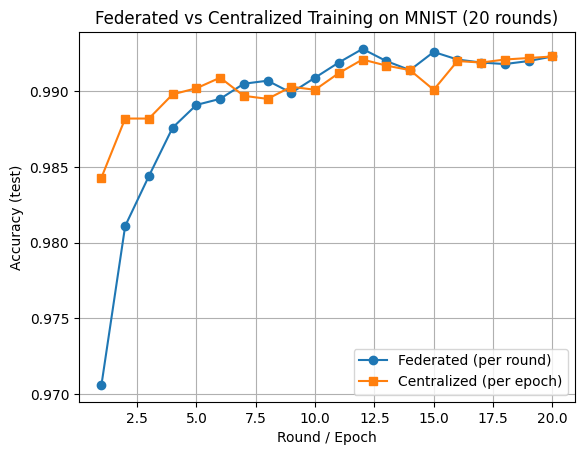

In [ ]:
import matplotlib.pyplot as plt

# --- Federated accuracy (por round) ---
fed_acc_hist = history_20.metrics_distributed.get("accuracy", [])
fed_rounds = [r for r, _ in fed_acc_hist]
fed_accs = [a for _, a in fed_acc_hist]

# --- Centralized accuracy (por epoch) ---
central_epochs = list(range(1, len(central_test_accs_20) + 1))
central_accs = central_test_accs_20

plt.figure()
plt.plot(fed_rounds, fed_accs, marker="o", label="Federated (per round)")
plt.plot(central_epochs, central_accs, marker="s", label="Centralized (per epoch)")
plt.xlabel("Round / Epoch")
plt.ylabel("Accuracy (test)")
plt.title("Federated vs Centralized Training on MNIST (20 rounds)")
plt.grid(True)
plt.legend()
plt.show()



# Conclusão: Federado × Centralizado
O desempenho do modelo treinado de forma centralizada foi comparado com o modelo treinado utilizando Aprendizado Federado (Federated Learning) com 5 clientes, variando o número de épocas/rounds em 10, 15 e 20. No treinamento centralizado, o modelo atingiu 99,11% de acurácia com 10 épocas, 99,20% com 15 épocas e 99,23% com 20 épocas. Observou-se que a acurácia já se aproximava de 99% por volta da época 6 a 8, indicando uma convergência rápida e estável, com redução suave e contínua do valor da loss ao longo do treinamento.

No cenário federado, os resultados foram bastante próximos. Com 10 rounds, a acurácia global chegou a 99,10%; com 15 rounds, atingiu 99,15%; e com 20 rounds, alcançou 99,23%, igualando o melhor resultado do modelo centralizado. Apesar de iniciar com acurácia um pouco menor (em torno de 96–97% no primeiro round), o modelo federado apresentou rápida evolução nos primeiros rounds. A curva de loss também mostrou tendência de queda consistente, porém com pequenas oscilações entre os rounds, comportamento esperado em ambientes federados devido à agregação de modelos treinados em subconjuntos diferentes dos dados.

Em termos de convergência, o treinamento centralizado se mostrou ligeiramente mais estável e direto, pois o modelo tem acesso a todos os dados simultaneamente. Já no aprendizado federado, cada cliente treina localmente com apenas uma fração do conjunto total, e o servidor realiza a agregação dos pesos por meio do algoritmo FedAvg. Esse processo introduz pequenas variações entre os rounds, o que pode tornar a convergência marginalmente mais lenta. Ainda assim, o desempenho final foi equivalente.

Do ponto de vista prático, o modelo centralizado possui a vantagem de menor complexidade de comunicação e, em geral, menor tempo total de treinamento. Por outro lado, o aprendizado federado oferece um benefício fundamental: os dados permanecem nos dispositivos dos clientes, aumentando a privacidade e reduzindo a necessidade de centralização de informações sensíveis. Esse aspecto é especialmente relevante em aplicações reais envolvendo dados pessoais, médicos ou financeiros.

Conclui-se que o aprendizado federado foi capaz de alcançar desempenho praticamente idêntico ao treinamento centralizado, chegando à mesma acurácia máxima de 99,23% no conjunto MNIST. Assim, os experimentos demonstram que o Federated Learning é uma alternativa viável ao treinamento tradicional, mantendo alta qualidade de modelo enquanto preserva a privacidade dos dados distribuídos, com o custo de maior comunicação e leve aumento no tempo de convergência.

## Atividade \#2: Aprendizado Federado em um Cenário Distribuído

Até aqui, o aprendizado federado foi realizado por meio de uma **simulação**, na qual clientes e servidor executam em um único ambiente. Em um cenário real, esses componentes seriam executados como **processos independentes**, possivelmente em máquinas diferentes, comunicando-se pela rede.

Nesta atividade, você deverá implementar um cenário mais próximo da realidade, separando explicitamente o código do cliente e do servidor federado.

### Tarefas
- Criar dois programas Python:
  - `client.py`
  - `server.py`
- O arquivo `client.py` deve:
  - implementar uma classe que herda de `NumPyClient` (Flower);
  - instanciar um cliente federado e conectá-lo ao servidor.
- O arquivo `server.py` deve:
  - configurar o servidor federado utilizando uma estratégia de agregação;
  - iniciar o servidor com **5 clientes**.
- Executar a solução utilizando **múltiplos terminais**:
  - 1 terminal para o servidor;
  - 5 terminais, um para cada cliente.
- Realizar experimentos variando o número de rounds em **2, 5, 10 e 20**.
- Plotar a **acurácia do modelo global** em função do número de rounds.

### Entregável
- Arquivos `client.py` e `server.py`.
- Gráfico(s) de acurácia.
- Breve descrição do ambiente e das decisões adotadas.


# Programa client.py

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import sys


import flwr as fl
from flwr.common import Context

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

def partition_dataset_iid(dataset, num_clients: int):
    """Particiona IID: divide índices em blocos iguais por cliente."""
    n = len(dataset)
    indices = np.random.permutation(n)
    splits = np.array_split(indices, num_clients)
    return [split.tolist() for split in splits]

NUM_CLIENTS = 5
client_partitions = partition_dataset_iid(trainset, NUM_CLIENTS)

BATCH_SIZE = 32

def get_client_loaders(cid: int):
    if not (0 <= cid < NUM_CLIENTS):
        raise ValueError(f"cid inválido: {cid} (esperado 0..{NUM_CLIENTS-1})")

    train_idx = client_partitions[cid]
    trainloader = DataLoader(Subset(trainset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(testset, batch_size=256, shuffle=False)
    return trainloader, testloader



# Definição do modelo de rede neural

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)         # 28 -> 14
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)         # 14 -> 7
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def get_model():
    return SimpleCNN().to(DEVICE)


# Funções de treinamento e avaliação do modelo

def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for x, y in trainloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(trainloader.dataset)

@torch.no_grad()
def evaluate(model, testloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y in testloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


# Implementação do cliente federado com Flower

def get_parameters(model):
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

def set_parameters(model, parameters):
    state_dict = model.state_dict()
    keys = list(state_dict.keys())
    new_state_dict = {k: torch.tensor(v) for k, v in zip(keys, parameters)}
    model.load_state_dict(new_state_dict, strict=True)

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid: int):
        self.cid = cid
        self.model = get_model()
        self.trainloader, self.testloader = get_client_loaders(cid)
        self.criterion = nn.CrossEntropyLoss()

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)

        lr = float(config.get("lr", 0.01))
        local_epochs = int(config.get("local_epochs", 1))

        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)

        for _ in range(local_epochs):
            train_one_epoch(self.model, self.trainloader, optimizer, self.criterion)

        return get_parameters(self.model), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        loss, acc = evaluate(self.model, self.testloader, self.criterion)
        return float(loss), len(self.testloader.dataset), {"accuracy": float(acc)}

# BLOCO FINAL — CONECTA AO SERVIDOR
if __name__ == "__main__":
    if len(sys.argv) != 2:
        print("Uso: python client.py <cid>")
        sys.exit(1)

    cid = int(sys.argv[1])
    print(f"Iniciando cliente {cid}...")

    fl.client.start_numpy_client(
        server_address="localhost:8080",
        client=FlowerClient(cid)
    )

# Programa Server.py

In [ ]:
import flwr as fl

NUM_CLIENTS = 5

# Lista para guardar a acurácia global a cada rodada
global_accuracies = []


# Config enviada aos clientes a cada round
def fit_config(server_round: int):
    return {
        "lr": 0.01,
        "local_epochs": 1,
    }


# Agregação das métricas vindas dos clientes
def evaluate_metrics_aggregation_fn(metrics):
    total_examples = sum(n for n, _ in metrics)
    agg = {}

    for n, m in metrics:
        for k, v in m.items():
            agg[k] = agg.get(k, 0.0) + (n / total_examples) * float(v)

    # Salva a acurácia agregada
    if "accuracy" in agg:
        global_accuracies.append(agg["accuracy"])
        print(f"[Round {len(global_accuracies)}] Acurácia global: {agg['accuracy']:.4f}")

    return agg


# Estratégia Federada
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)

# Número de rounds (2, 5, 10, 20 nos experimentos)
NUM_ROUNDS = 20


if __name__ == "__main__":
    print("Iniciando servidor Flower...")
    fl.server.start_server(
        server_address="0.0.0.0:8080",
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        strategy=strategy,
    )

    # Após o fim do treinamento, salva as acurácias em arquivo
    with open("accuracy_history.txt", "w") as f:
        for i, acc in enumerate(global_accuracies, start=1):
            f.write(f"{i},{acc}\n")

    print("Treinamento finalizado. Histórico de acurácia salvo em accuracy_history.txt")


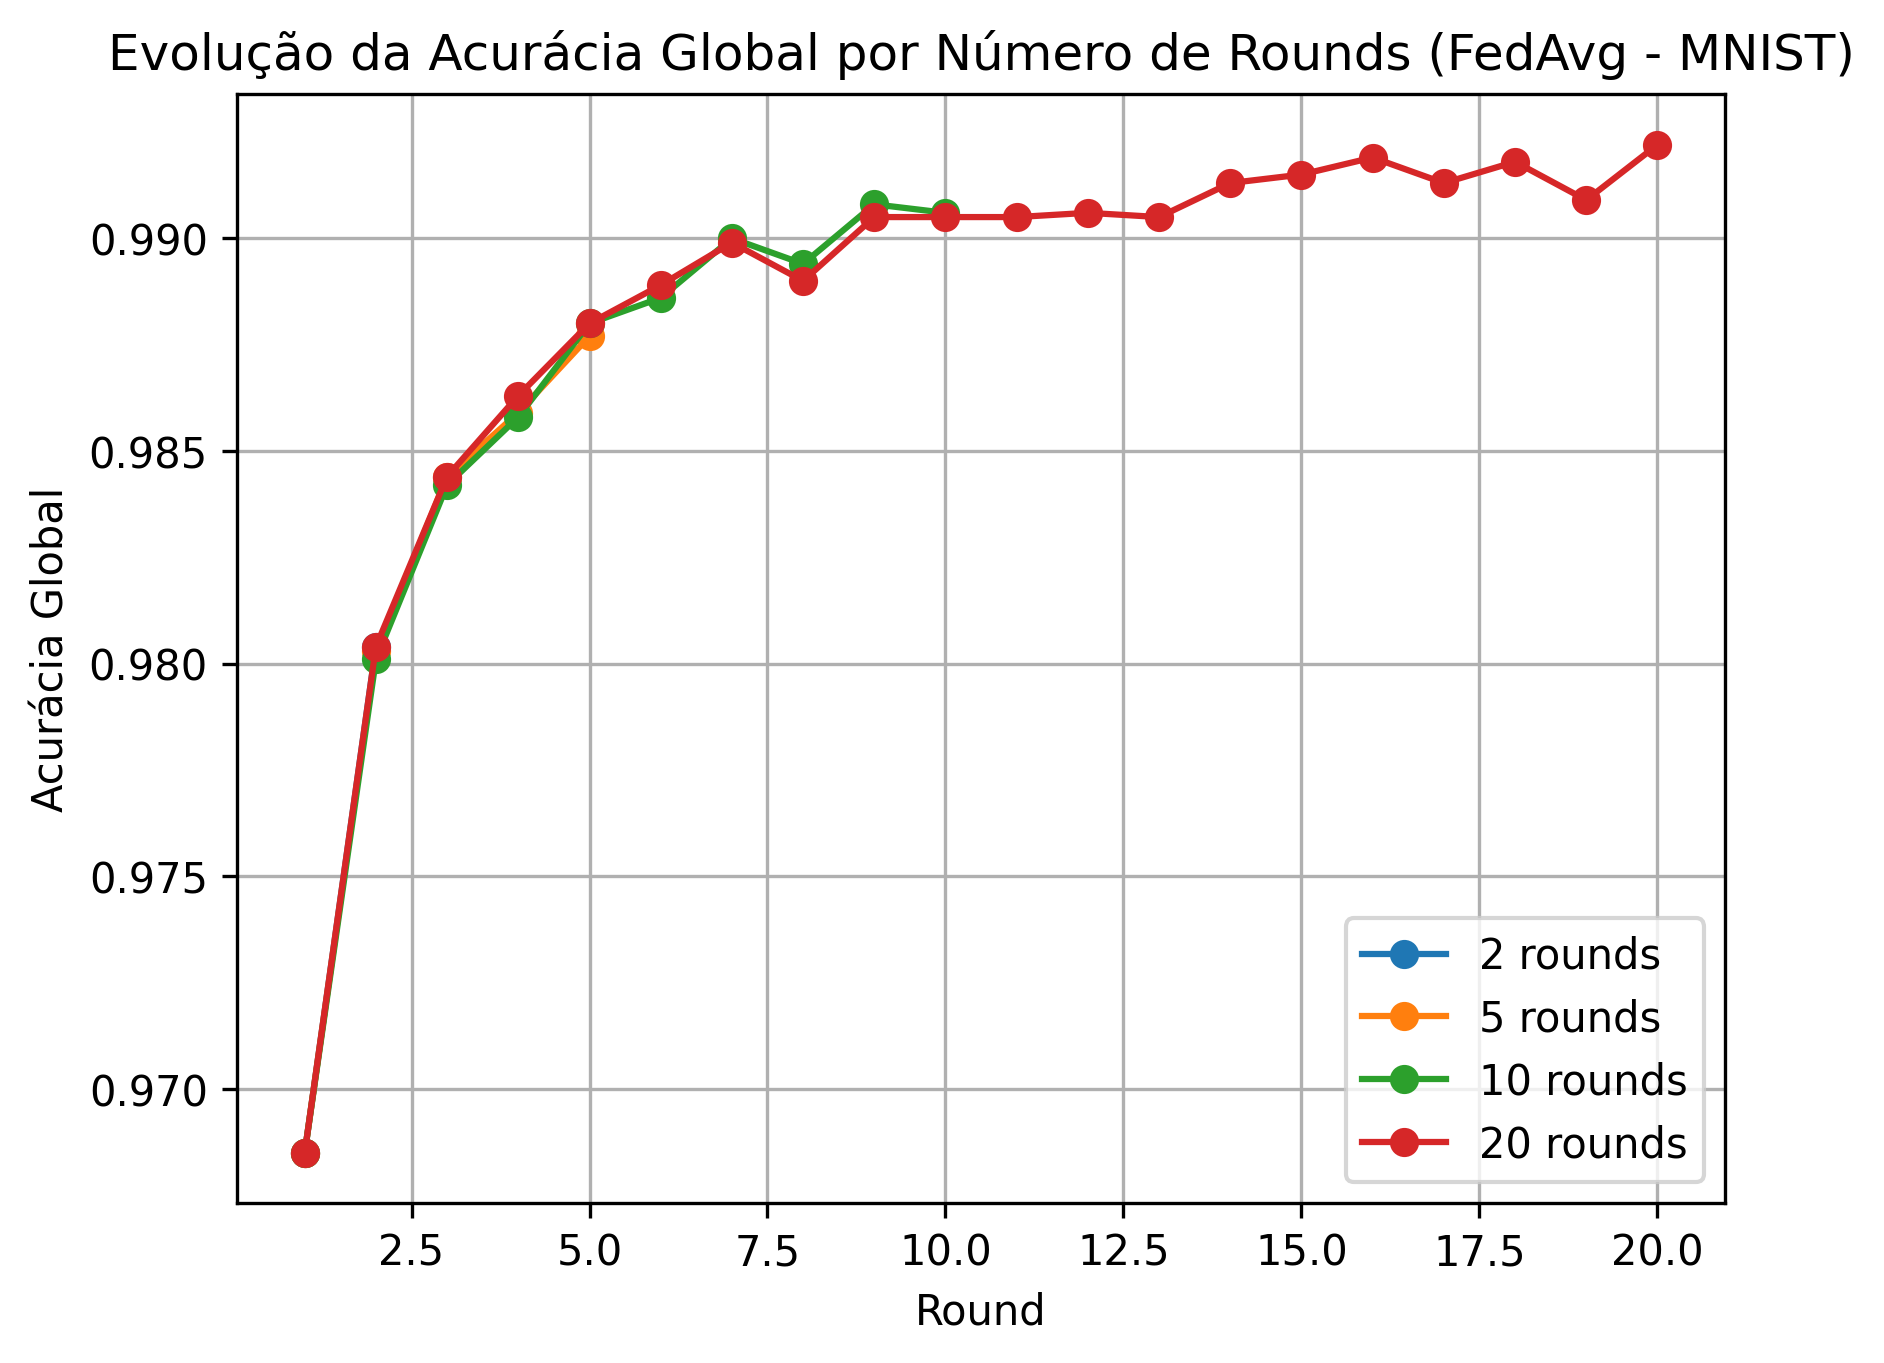

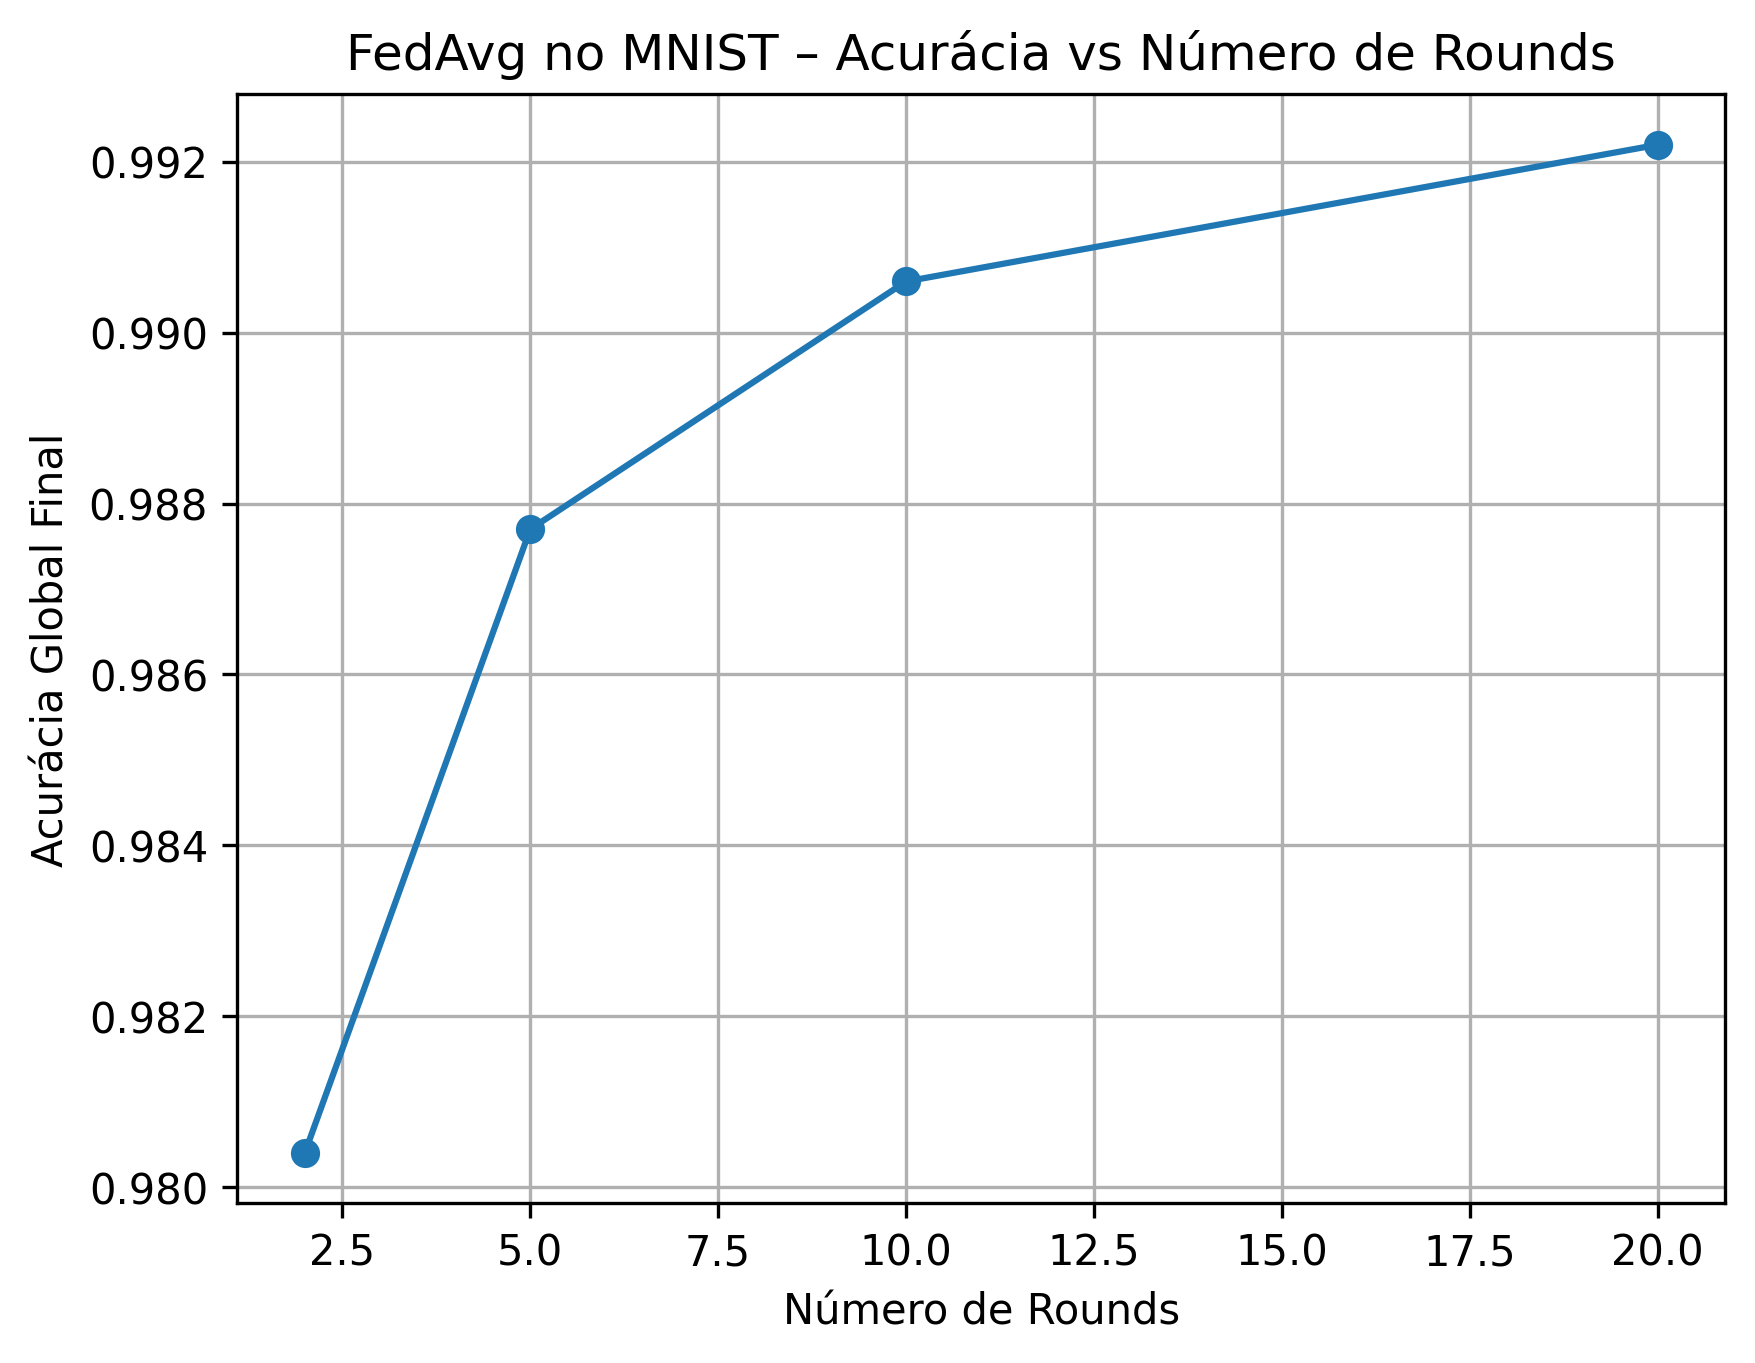

## Ambiente e Decisões Adotadas

Os experimentos de aprendizado federado foram realizados em um ambiente local, simulando um cenário distribuído com múltiplos processos independentes se comunicando pela rede. Foi utilizado o framework **Flower (FLWR)** para orquestração do treinamento federado e **PyTorch** para implementação e treinamento do modelo de rede neural.

O ambiente consistiu em:

* **Linguagem:** Python 3
* **Framework de Aprendizado Federado:** Flower
* **Framework de Deep Learning:** PyTorch + Torchvision
* **Dataset:** MNIST (classificação de dígitos manuscritos)
* **Execução:** 1 processo servidor + 5 processos clientes, rodando em terminais separados na mesma máquina (simulando dispositivos distribuídos)


## Modelo Utilizado
Foi adotada uma **rede neural convolucional simples (CNN)** composta por:

* 2 camadas convolucionais com função de ativação ReLU
* Camadas de *max pooling* para redução espacial
* 2 camadas totalmente conectadas
* Saída com 10 neurônios (uma classe para cada dígito do MNIST)


## Configuração dos Clientes

O conjunto de treino do MNIST foi particionado de forma **IID (Independent and Identically Distributed)** entre os 5 clientes. Cada cliente recebeu uma parte diferente dos dados, mas mantendo a mesma distribuição estatística global. Essa decisão foi tomada para:

* Simplificar a análise dos resultados
* Focar no comportamento do algoritmo federado (FedAvg)
* Evitar os efeitos adicionais de distribuições não-IID

Cada cliente realizou:

* **1 época de treino local por rodada**
* Otimizador **SGD com momentum (0.9)**
* Taxa de aprendizado **0.01**
* Função de perda **CrossEntropyLoss**

## Configuração do Servidor Federado
O servidor foi configurado utilizando a estratégia **FedAvg (Federated Averaging)**, que:

* Envia o modelo global para os clientes
* Recebe os modelos atualizados localmente
* Agrega os pesos por média ponderada pelo número de amostras de cada cliente

Todos os clientes participaram de todas as rodadas:

* `fraction_fit = 1.0`
* `fraction_evaluate = 1.0`

Isso garante que a atualização do modelo global considere o conhecimento de todos os participantes a cada rodada.

## Configuração dos Experimentos

Foram realizados experimentos variando o número de rodadas federadas:

* 2 rounds
* 5 rounds
* 10 rounds
* 20 rounds

A métrica principal avaliada foi a **acurácia do modelo global no conjunto de teste do MNIST** ao final de cada rodada. Os resultados foram salvos e posteriormente utilizados para gerar gráficos de evolução da acurácia.

## Justificativa das Decisões

As decisões adotadas (modelo simples, dados IID, todos os clientes ativos e poucos epochs locais) tiveram como objetivo:

* Facilitar a observação da convergência do aprendizado federado
* Reduzir o tempo de execução dos experimentos
* Permitir comparação clara com o treinamento centralizado

Esse cenário representa uma base controlada para entender o funcionamento do aprendizado federado antes de avançar para cenários mais complexos, como distribuições não-IID, falhas de clientes ou variações no número de participantes.

Dicas:

*   Não é necessário utilizar várias máquinas para isso;

*    Nesta atividade podemos emular uma rede por meio da interface de rede *localhost* (IP: 127.0.0.1) onde os processos treinadores e servidores podem ser executados em terminais Linux separados conectando-se pelo endereço IP 127.0.0.1;

